**Assignment 2** focuses on the training on a Neural Machine Translation (NMT) system with an attention model.

This is an **individual assignment** and usual rules for plagiarism apply! With this you agree that: "In submitting this work I confirm that it is entirely my own. I acknowledge that I may be invited to online interview if there is any concern in relation to the integrity of my exam." 

**Write comments and documentation.**



## Section 1- Data Collection and Preprocessing 


---


**Task 1  (5 marks)**

---

There are few datasets to train an NMT system available from the OPUS project (http://opus.nlpl.eu/).

*  Download a language pair (preferably European language) and **extract** the file(s) and upload it to CoLab
*  Create a list of lines by splitting the text file at every occurrence accordingly, i.e. source and target language
*  Print number of sentences
*  Limit the number of sentences to 10,000 lines (but more than 5,000 lines)
*  Split the data into train, development and test set
*  Print 100th sentence in original script for source and target language

In [1]:
# Importing relevant libraries
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from numpy import array
from numpy import asarray
from numpy import zeros
import os, sys
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
from keras.utils import plot_model
from nltk.translate.bleu_score import sentence_bleu

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file = open(r'drive/My Drive/datasets/fra.txt', encoding="utf-8") # English to french dataset

input_sentences = []                      # list to contain English (input) sentences
output_sentences = []                     # list to contain French (output) sentences

count = 0
for line in file:
    count += 1
    input_sentence, output_sentence = line.rstrip().split('\t') #  splitting the text file line
    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)

print("Number of senetence in original corpus : ",len(input_sentences)) # Number of sentences

# Limit the number of sentences to 10,000 lines (but more than 5,000 lines)
input_sentences = input_sentences[:10000]
output_sentences = output_sentences[:10000]

# Split the data into train, development and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_sentences, output_sentences, test_size=0.2, random_state=42)

# Print 100th sentence in original script for source and target language
print("\n100th senetnce in Source Language : ",X_train[100]," , Target Language : ",y_train[100])

Mounted at /content/drive
Number of senetence in original corpus :  149861

100th senetnce in Source Language :  He's so stupid.  , Target Language :  Il est tellement idiot !


**Task 2 (5 marks)** 

---

* Add '<bof\>' to denote beginning of sentence and '<eos\>' to denote the end of the sentence to each target line.
* Perform the pre-processing step of the text.
* Print the last 5 sentences of the preprocessed text.
* Print statistics on the selected dataset:
  * Number of samples
  * Number of unique source language tokens
  * Number of unique target language tokens
  * Max sequence length of source language
  * Max sequence length of target language
  * Source Vocabulary
  * Target Vocabulary





In [3]:
input_sentences = []          # list containing inputs of encoder
output_sentences = []         # list containing output of decoder
output_sentences_inputs = []  # list containing input of decoder

def preprocess(seq):          # Utility function to preprocess strings
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~''' # initializing punctuations string 
    # Removing punctuations in string
    for ele in seq: 
        if ele in punc: 
            seq = seq.replace(ele, "") 
    line = seq.split()
    line = [word.lower() for word in line]
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # remove non-printable chars form each token
    line = [re_print.sub('', w) for w in line]
    return " ".join(line)

for i in range(len(X_train)):
    input_sentence = preprocess(X_train[i])
    output = y_train[i]
    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of input samples :", len(input_sentences))
print("Number of output samples:", len(output_sentences))
print("Number of input output samples:", len(output_sentences_inputs))

total_input = input_sentences +  [preprocess(line) for line in X_test]
max_input_len = max([len(txt.split()) for txt in total_input])
print("Max length for input : : ",max_input_len)
print("Max length for output:",max([len(txt.split()) for txt in output_sentences]))

unique_input_tokens = set()
for line in total_input:
    words = line.split()
    for word in words:
        unique_input_tokens.add(word)
print("Unique tokens for inputs : ",len(unique_input_tokens))

unique_output_tokens = set()
for line in output_sentences:
    words = line.split()
    for word in words:
        unique_output_tokens.add(word)
print("Unique tokens for outputs : ",len(unique_output_tokens))

# last 5 sentences of preprocessed text
print("\nLast 5 sentences of preprocessed text")
for inpu,outpu in zip(input_sentences[-5:],output_sentences[-5:]):
  print(inpu,"   -->   ",outpu)

Number of input samples : 8000
Number of output samples: 8000
Number of input output samples: 8000
Max length for input : :  5
Max length for output: 11
Unique tokens for inputs :  2154
Unique tokens for outputs :  5143

Last 5 sentences of preprocessed text
ring the bell    -->    Sonnez la cloche. <eos>
i told you so    -->    Je vous l'ai dit ! <eos>
im not alone    -->    Je ne suis pas seul. <eos>
wait here    -->    Attends là. <eos>
i hurt my foot    -->    Je me suis fait mal au pied. <eos>


**Task 3 (5 marks)** 

---

---

*  Assign each unique word an integer value (5 marks).
*  Create word embedding for your vocabulary using pre-trained embeddings, for example GloVe or fastText (10 marks) (https://nlp.stanford.edu/projects/glove/ , https://fasttext.cc/docs/en/english-vectors.html)
* Print the first line of the embeddings (see below) 

In [4]:
# Tokenization (Assign each unique word an integer value)
MAX_NUM_WORDS = 20000

input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(total_input)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)


output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the input: 2154
Length of longest sentence in input: 5
Total unique words in the output: 5117
Length of longest sentence in the output: 11


In [5]:
# Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences    
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[0]:", encoder_input_sequences[0])

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post') # in the case of the decoder, the post-padding is applied
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[0]:", decoder_input_sequences[0])
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

encoder_input_sequences.shape: (8000, 5)
encoder_input_sequences[0]: [  0   0  18   2 864]
decoder_input_sequences.shape: (8000, 11)
decoder_input_sequences[0]: [  2 803   9 804   5   0   0   0   0   0   0]


In [7]:
# Word Embeddings (word embeddings capture a lot more information about words)
""" With integer reprensentation, a word is represented only with a single integer. 
With vector representation a word is represented by a vector of 50, 100, 200, or 
whatever dimensions you like. Hence, word embeddings capture a lot more information about words. 
Secondly, the single-integer representation doesn't capture the relationships between different words."""
EMBEDDING_SIZE = 100
embeddings_dictionary = dict()

glove_file = open(r'drive/My Drive/datasets/glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)

embedding_matrix = zeros((num_words, EMBEDDING_SIZE)) # dictionary for key: number to value: embedding values of len 100
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print("Embedding : ",embeddings_dictionary["what"]) # dictionary for key: word to value: embedding values of len 100
print("Length of embeddings :",len(embeddings_dictionary["what"]))
print(embedding_matrix[100])   

Embedding :  [-1.5180e-01  3.8409e-01  8.9340e-01 -4.2421e-01 -9.2161e-01  3.7988e-02
 -3.2026e-01  3.4119e-03  2.2101e-01 -2.2045e-01  1.6661e-01  2.1956e-01
  2.5325e-01 -2.9267e-01  1.0171e-01 -7.5491e-02 -6.0406e-02  2.8194e-01
 -5.8519e-01  4.8271e-01  1.7504e-02 -1.2086e-01 -1.0990e-01 -6.9554e-01
  1.5600e-01  7.0558e-02 -1.5058e-01 -8.1811e-01 -1.8535e-01 -3.6863e-01
  3.1650e-02  7.6616e-01  8.4041e-02  2.6928e-03 -2.7440e-01  2.1815e-01
 -3.5157e-02  3.2569e-01  1.0032e-01 -6.0932e-01 -7.0316e-01  1.8299e-01
  3.3134e-01 -1.2416e-01 -9.0542e-01 -3.9157e-02  4.4719e-01 -5.7338e-01
 -4.0172e-01 -8.2234e-01  5.5740e-01  1.5101e-01  2.4598e-01  1.0113e+00
 -4.6626e-01 -2.7133e+00  4.3273e-01 -1.6314e-01  1.5828e+00  5.5081e-01
 -2.4738e-01  1.4184e+00 -1.6867e-02 -1.9368e-01  1.0090e+00 -5.9864e-02
  9.1853e-01  4.3022e-01 -2.0624e-01  7.6127e-02  2.1595e-01 -2.6834e-01
 -3.3342e-01 -3.7151e-01  4.5197e-01 -8.2460e-02  3.2984e-01 -5.7376e-01
 -1.3042e+00  2.7121e-01  6.6277e-01 -

## Section 2 Translation Model training



---



**Task 4 (15 marks)**
* Provide code for the encoder using Keras LSTM (5 marks)
* Provide code for the decoder using Keras LSTM (5 marks)
* Train the sequence2sequence (encoder-decoder) model (5 marks) 


In [8]:
# Model defining
# Output will be a sequence of words, the final shape of the output will be:(number of inputs, length of the output sentence, the number of words in the output)
decoder_targets_one_hot = np.zeros((len(input_sentences),max_out_len,num_words_output),dtype='float32')
print(decoder_targets_one_hot.shape)

# The final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors,
# since we will be using softmax activation function at the dense layer.
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1  

(8000, 11, 5118)


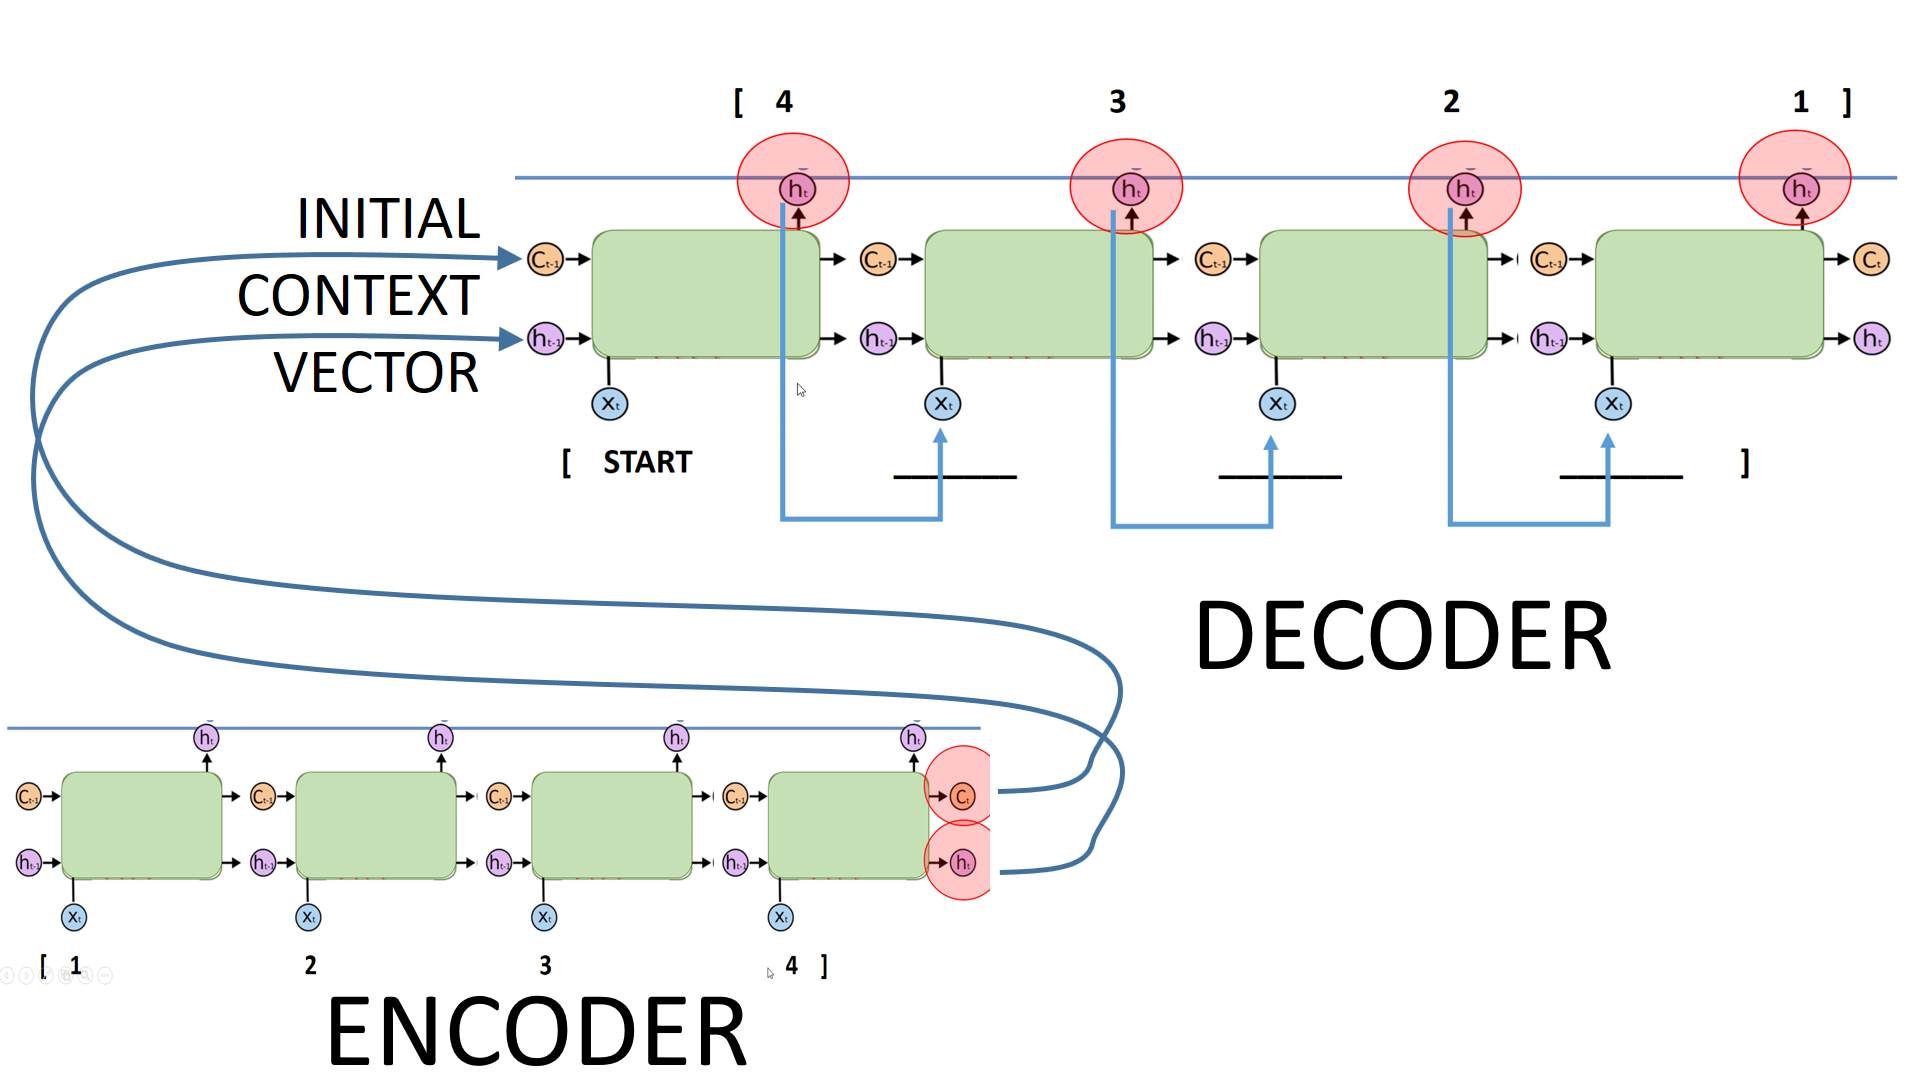

In [9]:
# Encoder
LSTM_NODES =256
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256

embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [10]:
# Decoder
decoder_inputs_placeholder = Input(shape=(max_out_len,))
decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [11]:
model = Model([encoder_inputs_placeholder,decoder_inputs_placeholder], decoder_outputs)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 100)       215500      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 11, 256)      1310208     input_2[0][0]                    
______________________________________________________________________________________________

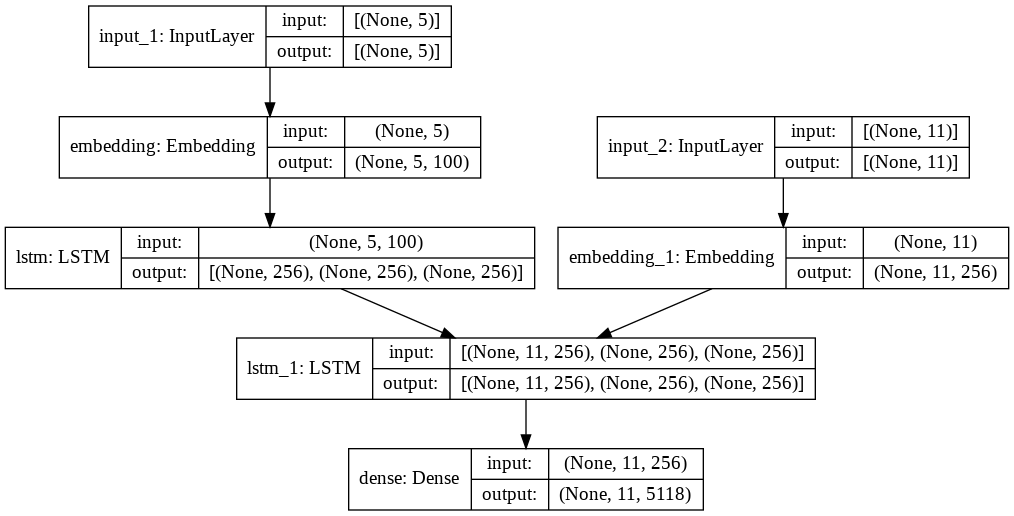

In [12]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
history = model.fit([encoder_input_sequences, decoder_input_sequences],decoder_targets_one_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.1,)
model.save('seq2seq_source_target.h5')

Epoch 1/20
113/113 [==============================] - 36s 283ms/step - loss: 3.2840 - accuracy: 0.6044 - val_loss: 2.0693 - val_accuracy: 0.7003
Epoch 2/20
113/113 [==============================] - 31s 276ms/step - loss: 1.8419 - accuracy: 0.7206 - val_loss: 1.8574 - val_accuracy: 0.7351
Epoch 3/20
113/113 [==============================] - 31s 274ms/step - loss: 1.5826 - accuracy: 0.7575 - val_loss: 1.6943 - val_accuracy: 0.7553
Epoch 4/20
113/113 [==============================] - 31s 276ms/step - loss: 1.4022 - accuracy: 0.7814 - val_loss: 1.5985 - val_accuracy: 0.7716
Epoch 5/20
113/113 [==============================] - 31s 275ms/step - loss: 1.2947 - accuracy: 0.7954 - val_loss: 1.5146 - val_accuracy: 0.7818
Epoch 6/20
113/113 [==============================] - 31s 275ms/step - loss: 1.2050 - accuracy: 0.8047 - val_loss: 1.4787 - val_accuracy: 0.7880
Epoch 7/20
113/113 [==============================] - 31s 275ms/step - loss: 1.1262 - accuracy: 0.8141 - val_loss: 1.4593 - val_ac

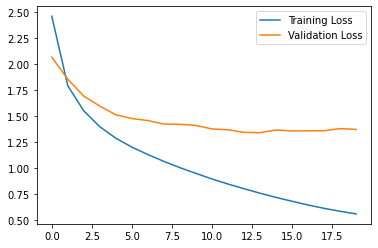

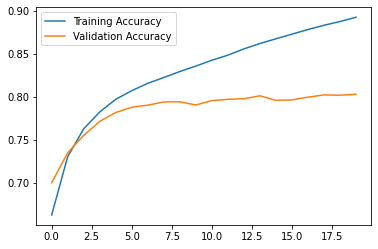

In [14]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

## Section 3 Testing

---

**Task 5 (20 marks)**

* Use the trained model to translate the text from the source into the target language (10 marks). 
* Use the test/evaluation set (see Section 1) and perform an automatic evaluation with the BLEU metric (10 marks). 
You can use the NLTK library to calculate BLEU.

In [15]:
# Prediction
encoder_model = Model(encoder_inputs_placeholder, encoder_states)
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
# Dictionaries for both inputs and outputs where the keys will be the integers and the corresponding values will be the words
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

# utility function for inference phase
def inference(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])
        if eos == idx:
            break
        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [18]:
# Testing on few random samples
for _ in range(10):
    i = np.random.choice(len(input_sentences))
    eng_sen = encoder_input_sequences[i:i+1]
    translation = inference(eng_sen)
    print('*********************************************')
    print('English: {}'.format(input_sentences[i]))
    print('Prediction: {}'.format(translation))
    print('Ground truth: {}'.format(output_sentences[i]))

*********************************************
English: catch tom
Prediction: attrape tom.
Ground truth: Attrape Tom. <eos>
*********************************************
English: we saw you
Prediction: nous vous avons vues.
Ground truth: Nous t'avons vu. <eos>
*********************************************
English: dont move
Prediction: ne bougez pas !
Ground truth: Ne bouge pas. <eos>
*********************************************
English: he was stunned
Prediction: il était paralysé.
Ground truth: Il fut paralysé. <eos>
*********************************************
English: be discreet
Prediction: soyez discrète !
Ground truth: Soyez discrètes ! <eos>
*********************************************
English: no one knew it
Prediction: personne ne le l'a dit.
Ground truth: Personne ne le savait. <eos>
*********************************************
English: hes smart
Prediction: il est en colère.
Ground truth: Il est intelligent. <eos>
*********************************************
English: th

In [20]:
# Automatic evaluation with the BLEU metric
def encode_to_input(s):
    s = preprocess(s)
    x  = []
    for w in s.split():
        x.append(word2idx_inputs[w.lower()])
    return pad_sequences([x], maxlen=max_input_len)
    
# Calculating average BLEU score on test set (2000 size in our case)
def evaluate_model(X,Y):
    count = 0
    total_score = 0
    for x,y in zip(X,Y):
        encoded_x = encode_to_input(x)
        translated_x =inference(encoded_x)
        reference = [y.split()]
        candidate = translated_x.split()
        blue_score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
        count = count +1
        total_score = total_score + blue_score
        if count%100==0:
          print(count,blue_score,total_score,x,y)
    return total_score/count

average_score = evaluate_model(X_test,y_test)
print("Average BLEU score",average_score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


100 0.25 24.01194318422607 I hate to iron. Je déteste repasser.
200 0 48.33385161901008 She liked it. Elle l'apprécia.
300 0.8 72.35375369767654 I'm not sleepy. Je ne suis pas endormi.
400 0 96.41221871978186 Go on. Poursuivez.
500 0 122.13802767743523 He went to bed. Il se mit au lit.
600 0 148.09174531904236 I got hot. Je me suis mis à avoir chaud.
700 0 171.00974030799117 I hope not. Je n'espère pas.
800 0 196.45362860443177 It's Tom. C'est Tom.
900 0.6666666666666666 218.08710365724565 I can walk. Je peux marcher.
1000 0 239.42396010149068 I'm so unlucky! Quelle poisse j'ai !
1100 0 265.56512341522404 I was there. Je m'y trouvais.
1200 0 291.0572957517846 I predicted it. Je l'avais prédit.
1300 0 317.7669063625534 It's all right. Tout va bien.
1400 0 341.6500498590941 You all right? Tu vas bien ?
1500 0.4 364.69184972712026 I felt awful. Je me sentis affreusement mal.
1600 0.6666666666666666 390.7101855646858 We got lucky. On a eu de la chance.
1700 0.5 415.1195660391634 Cut it out

Even though the average blue score is less than 0.3, I still feel the quality of translation is still good as compared with few trails with google translate.

# Section 4 Attention

---



**Task 5 (40 Marks)** Sequence2Sequence

* Extend the existing Seq2Seq model with an attention mechanism [Discussed in Class]
* Create sequence2sequence model with attention (15 marks)
* Train the model with the same data from Section 1 (10 marks)
* Translate the evaluation set using the sequence2sequence attention model (10 marks)
* Evaluate the translations made with the sequence2sequence attention model and compare it with the model without attention using BLEU (5 marks)

In [22]:
#Import relavent libraries
from tensorflow.keras.layers import Embedding, Input, LSTM, GRU, Dense, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

In [23]:
# Creating a BiLSTM Attention based model

# Embedding
embedding = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

# Encoder
input_layer_encoder = Input(shape=(max_input_len,))
embed_encoder = embedding(input_layer_encoder)
encoder = Bidirectional(LSTM(LSTM_NODES, return_sequences=True, dropout=0.2))
encoder_out = encoder(embed_encoder)

# Decoder input
input_layer_decoder = Input(shape=(max_out_len,))
embed_decoder = Embedding(num_words_output, EMBEDDING_SIZE)
decoder_input = embed_decoder(input_layer_decoder)

# Decoder output, after attention
decoder = LSTM(LSTM_NODES, return_state=True)
dense_decode = Dense(num_words_output, activation='softmax')
s0 = Input(shape=(LSTM_NODES,))
c0 = Input(shape=(LSTM_NODES,))

Each attention iteration, the hidden states, encoded by the encoder, is concatenated with the predicted output of the previous word.
 
 context vector by performing dot product: $context=\sum_{t'=1}^{|T_{x}|} \alpha(t')h(t')$
.

The context vector is passed through a "softmax over time" layer to become the input to the decoder LSTM.
 "softmax over time" activation function is implemented as follows: $\alpha(t') = \dfrac {exp(s(t'))}{\sum_{x=1}^{|T_{x}|} exp(s(x)) }$

In [24]:
def softmax(x):
    assert(K.ndim(x) > 2) #Dimension x = N x T x D
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

# Some of the common layers for attention
repeat_attn = RepeatVector(max_input_len)
concat_attn = Concatenate(axis=-1)
dense1_attn = Dense(10, activation='tanh')  # over time dimension T
dense2_attn = Dense(1, activation=softmax)
dot_attn = Dot(axes=1)                      # over time dimension T

def iterAttn(h, prevOut):
    #  h: encoder encoded hidden states at all time.
    # prevOut: output at the previous time (word).
    # An iteration of attention.
    prevOutRepeat = repeat_attn(prevOut) 
    total = concat_attn([h, prevOutRepeat]) 
    d = dense1_attn(total)
    alphaLayer = dense2_attn(d)
    context = dot_attn([alphaLayer, h])
    return context

In [25]:
# Initializing with start states
s = s0
c = c0
# Executing encoder-decoder and attention (with teacher forcing) inference for Ty time to get output
all_out = []
for t in range(max_out_len):
    # Get context vector with encoder and attention
    context = iterAttn(encoder_out, s) 
    # For teacher forcing, get the previous word
    select_layer = Lambda(lambda x: x[:, t:t+1])
    prevWord = select_layer(decoder_input)
    # Concat context and previous word as decoder input
    concat2 = Concatenate(axis=2)
    decoder_in_concat = concat2([context, prevWord])
    # pass into decoder, inference output
    pred, s, c = decoder(decoder_in_concat, initial_state=[s, c])
    pred = dense_decode(pred)
    all_out.append(pred)
       
def stack(outputs):
    outputs = K.stack(outputs)
    return K.permute_dimensions(outputs, pattern=(1, 0, 2))

stack_layer = Lambda(stack)
all_out = stack_layer(all_out)

In [26]:
attnModel = Model(inputs=[input_layer_encoder, input_layer_decoder, s0, c0,],
                 outputs=all_out)

In [27]:
# Defining cutomized loss and accuracy
def myLoss(y_train, pred):
    mask = K.cast(y_train > 0, dtype='float32')
    val = mask * y_train * K.log(pred)
    return -K.sum(val) / K.sum(mask)

def acc(y_train, pred):
    targ = K.argmax(y_train, axis=-1)
    pred = K.argmax(pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')
    mask = K.cast(K.greater(targ, 0), dtype='float32') # filter out padding value 0.
    correctCount = K.sum(mask * correct)
    totalCount = K.sum(mask)
    return correctCount / totalCount

In [28]:
attnModel.compile(optimizer='adam', loss=myLoss, metrics=[acc]) # Training with Adam optimizer and customized loss and accuracy

# Defining empty s0 and c0
init_s = np.zeros((len(encoder_input_sequences), LSTM_NODES))
init_c = np.zeros((len(encoder_input_sequences), LSTM_NODES))

EPOCHS = 40
history = attnModel.fit(x=[encoder_input_sequences, decoder_output_sequences, init_s, init_c],y=decoder_targets_one_hot,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.1)

Epoch 1/40
113/113 [==============================] - 82s 519ms/step - loss: 4.2721 - acc: 0.0012 - val_loss: 2.5702 - val_acc: 0.0779
Epoch 2/40
113/113 [==============================] - 52s 462ms/step - loss: 2.3612 - acc: 0.1190 - val_loss: 2.4714 - val_acc: 0.1405
Epoch 3/40
113/113 [==============================] - 52s 461ms/step - loss: 2.2373 - acc: 0.1722 - val_loss: 2.4196 - val_acc: 0.1785
Epoch 4/40
113/113 [==============================] - 52s 458ms/step - loss: 2.1677 - acc: 0.2050 - val_loss: 2.3872 - val_acc: 0.1933
Epoch 5/40
113/113 [==============================] - 52s 458ms/step - loss: 2.1004 - acc: 0.2162 - val_loss: 2.3440 - val_acc: 0.2020
Epoch 6/40
113/113 [==============================] - 52s 458ms/step - loss: 2.0520 - acc: 0.2324 - val_loss: 2.2955 - val_acc: 0.2213
Epoch 7/40
113/113 [==============================] - 53s 468ms/step - loss: 1.9727 - acc: 0.2450 - val_loss: 2.2560 - val_acc: 0.2543
Epoch 8/40
113/113 [==============================] - 5

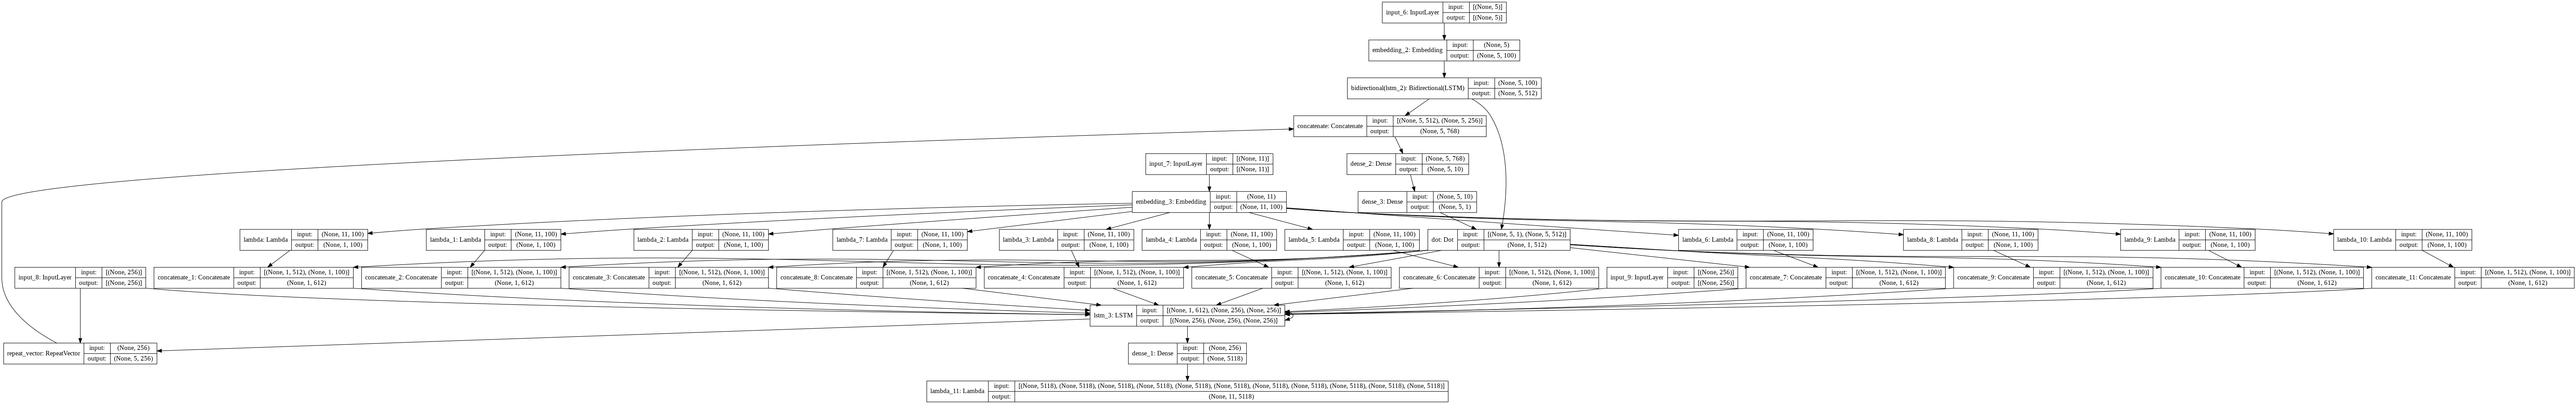

In [31]:
plot_model(attnModel, to_file='att_model_plot.png', show_shapes=True, show_layer_names=True)

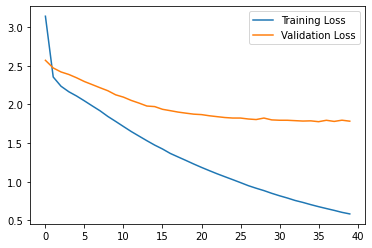

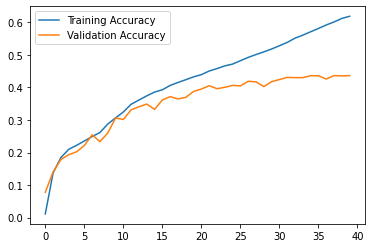

In [30]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["acc"], label="Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.show()

In [32]:
# Inference model
# Encoder
encoder_inf = Model(input_layer_encoder, encoder_out)
encoder_out_inf = Input(shape=(max_input_len, LSTM_NODES * 2,))

# Decoder
decoder_in_inf = Input(shape=(1,))
decoder_in_embed_inf = embed_decoder(decoder_in_inf)

# Context, concat without teacher forcing.
context_inf = iterAttn(encoder_out_inf, s0)
decoder_in_concat_inf = concat2([context_inf, decoder_in_embed_inf])

# Decoder inference
pred, s, c = decoder(decoder_in_concat_inf, initial_state=[s0, c0])
pred_out = dense_decode(pred)

# Define model
decoder_inf = Model(inputs=[decoder_in_inf, encoder_out_inf, s0, c0],outputs=[pred_out, s, c])

In [33]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

def inference_att(eng_seq):
    encoder_output = encoder_inf.predict(eng_seq) # Encode
    # Create output seq matrix
    target_output = np.zeros((1, 1))
    target_output[0, 0] = word2idx_outputs['<sos>']
    
    # init
    eos = word2idx_outputs['<eos>']
    s0 = np.zeros((1, LSTM_NODES))
    c0 = np.zeros((1, LSTM_NODES))
    output_seq = []
    s = s0
    c = c0
    for _ in range(max_out_len):
        # Decoder inference
        pred, s, c = decoder_inf.predict([target_output, encoder_output, s, c])
        
        # update output seq
        tok = np.argmax(pred.flatten())
        if tok == eos:
            break
        if tok > 0:
            word = idx2word_target[tok]
            output_seq.append(word)

        # Update decoder input
        target_output[0, 0] = tok
      
    sentence = ' '.join(output_seq)
    return sentence

In [35]:
for _ in range(10):
    i = np.random.choice(len(input_sentences))
    eng_sen = encoder_input_sequences[i:i+1]
    translation = inference_att(eng_sen)
    print('*********************************************')
    print('English: {}'.format(input_sentences[i]))
    print('Prediction: {}'.format(translation))
    print('Ground truth: {}'.format(output_sentences[i]))

*********************************************
English: get my rifle
Prediction: attrapez mon fusil !
Ground truth: Attrapez mon fusil ! <eos>
*********************************************
English: i hate that
Prediction: je déteste ça.
Ground truth: Je déteste ça. <eos>
*********************************************
English: youre lying
Prediction: tu es
Ground truth: Vous mentez. <eos>
*********************************************
English: time flies
Prediction: le est s'envole.
Ground truth: Le temps s'envole. <eos>
*********************************************
English: take your shot
Prediction: à les votre tirer !
Ground truth: À toi de tirer ! <eos>
*********************************************
English: were sinking
Prediction: nous coulons.
Ground truth: Nous sommes en train de couler. <eos>
*********************************************
English: they said yes
Prediction: ils ont dit non.
Ground truth: Ils ont dit oui. <eos>
*********************************************
English: jo

In [36]:
def evaluate_model(X,Y):
    count = 0
    total_score = 0
    for x,y in zip(X,Y):
        encoded_x = encode_to_input(x)
        translated_x = inference_att(encoded_x)
        reference = [y.split()]
        candidate = translated_x.split()
        blue_score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
        count = count +1
        total_score = total_score + blue_score
        if count%100==0:
          print(count,blue_score,total_score,x,y)
    return total_score/count

average_score_att = evaluate_model(X_test,y_test)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


100 0.25 25.053959645405524 I hate to iron. Je déteste repasser.
200 0 50.091770003468575 She liked it. Elle l'apprécia.
300 0.38940039153570244 75.51904853120914 I'm not sleepy. Je ne suis pas endormi.
400 0 101.20595255327791 Go on. Poursuivez.
500 0 124.92212140486325 He went to bed. Il se mit au lit.
600 0.23618327637050734 150.92230071055207 I got hot. Je me suis mis à avoir chaud.
700 0 172.88815387036612 I hope not. Je n'espère pas.
800 0 198.55886065329466 It's Tom. C'est Tom.
900 0.6666666666666666 223.166075916009 I can walk. Je peux marcher.
1000 0 243.4039581245883 I'm so unlucky! Quelle poisse j'ai !
1100 0 269.4860519036005 I was there. Je m'y trouvais.
1200 0 295.49139631750484 I predicted it. Je l'avais prédit.
1300 0 322.1518347444275 It's all right. Tout va bien.
1400 0 348.9575200469261 You all right? Tu vas bien ?
1500 0.5 375.75727754386435 I felt awful. Je me sentis affreusement mal.
1600 0.3333333333333333 399.23603395083944 We got lucky. On a eu de la chance.
17

In [39]:
print("Average BLEU score with attention model",average_score_att)

Average BLEU score with attention model 0.24641285556712872


How further model can be improved:
1. More data
2. Lesser overfitting using practices like regularization etc.
3. Stronger pretrained models and retraining them like Google's T5 etc.

# References:



1.   https://opus.nlpl.eu/
2.   http://jalammar.github.io/illustrated-transformer/
3.   https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
4.   https://betterprogramming.pub/a-guide-on-the-encoder-decoder-model-and-the-attention-mechanism-401c836e2cdb
5.   https://keras.io/api/layers/attention_layers/attention/
6.   https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb
7.   https://www.kaggle.com/residentmario/seq-to-seq-rnn-models-attention-teacher-forcing
8.   https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/
9.   https://medium.com/deep-learning-with-keras/seq2seq-part-f-encoder-decoder-with-bahdanau-luong-attention-mechanism-ca619e240c55
10. https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/
11. https://github.com/shawnhan108/Attention-LSTMs/tree/master/English%20to%20Italian%20Machine%20Translation%20with%20BiLSTM%20and%20Attention
12. https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39




